In [1]:
import pandas as pd
import os, re
import csv

In [2]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [3]:
chdir = True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [5]:
# Metadata for specific SFC configurations
exp_ls = "exp10"
exp_rs = "exp37"
vnfs = ["firewall.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]

In [6]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []

    if file.startswith("latency.csv"):
        with open(os.path.join(exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for line in lines:
                try:
                    value = float(line.strip()) / 1000
                except ValueError:
                    value = "N/A"
                tmp.append(value)
    else:
        with open(os.path.join(exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = "N/A"
                tmp.append(value)

    return tmp

In [51]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join(exp_type, exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                stat.append(line.strip().split(',')[index])
    
    return list(map(lambda x:float(x), stat[:-1]))

In [7]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join(exp_type, exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                try:
                    value = float(line.strip().split(',')[index])
                except ValueError:
                    value = "N/A"
                stat.append(value)

    return stat

In [8]:
latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
len(latency)

360

In [9]:
latency_1 = parse_seq("resource_stimulus", exp_rs, "latency.csv")
len(latency_1)

80

In [10]:
tx_stats_1 = parse_seq("resource_stimulus", exp_rs, "tx_stats.csv")
len(tx_stats_1)

42

In [11]:
tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
len(tx_stats)

179

In [12]:
rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
len(rx_stats)

179

In [13]:
firewall_instructions = parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)
len(firewall_instructions)

179

In [14]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",]

In [15]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
    
    latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
 
    
    seq_length = min([len(parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)), \
                          len(tx_stats), \
                          len(rx_stats), \
                          len(latency)])
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_ls, v, f, 1)
            
            dic[v.split(".")[0]+"_"+f.replace(",","")] = tmp[:seq_length]
            
    return pd.DataFrame(dic)

In [16]:
df = make_df()

<Axes: >

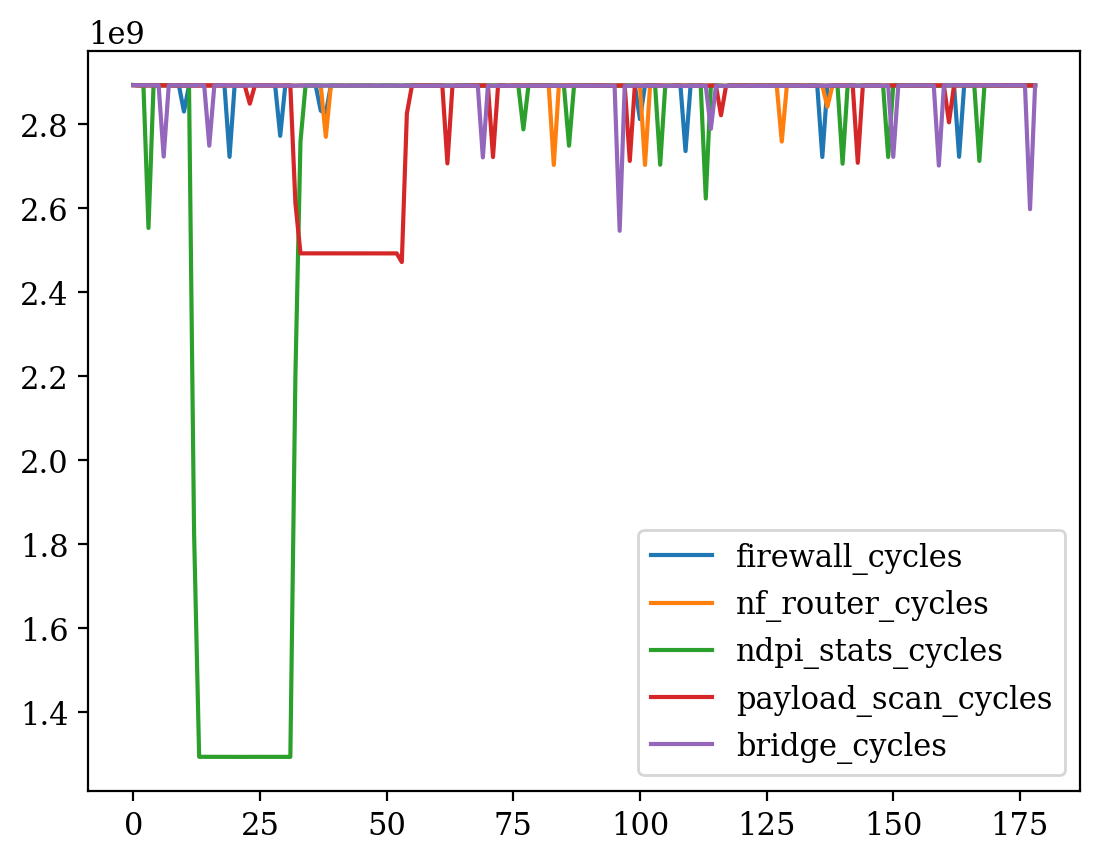

In [17]:
df[["firewall_cycles","nf_router_cycles","ndpi_stats_cycles","payload_scan_cycles","bridge_cycles"]].plot()

In [18]:
df.to_csv("load_stimulus_"+ exp_ls +".csv", sep=',')

In [19]:
df.to_csv("resource_stimulus_"+ exp_rs +".csv", sep=',')

In [20]:
folder_path = '../linear/load_stimulus'
file_name = 'load_stimulus_' + exp_ls + '.csv'
file_path = os.path.join(folder_path, file_name)
df.to_csv(file_path, sep=',', index=False)


In [21]:
folder_path = '../linear/resource_stimulus'
file_name = 'resource_stimulus_' + exp_rs + '.csv'
file_path = os.path.join(folder_path, file_name)
df.to_csv(file_path, sep=',', index=False)